# Your First AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use your trained model to perform inference on flower images.

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

## Install Datasets and Upgrade TensorFlow

To ensure we can download the latest version of the `oxford_flowers102` dataset, let's first install both `tensorflow-datasets` and `tfds-nightly`.
* `tensorflow-datasets` is the stable version that is released on a cadence of every few months
* `tfds-nightly` is released every day and has the latest version of the datasets

We'll also upgrade TensorFlow to ensure we have a version that is compatible with the latest version of the dataset.

In [2]:
#run this and restart kernel and then run the below
%pip --no-cache-dir install tensorflow-datasets --user

Note: you may need to restart the kernel to use updated packages.


In [1]:
!pip install grpcio
!pip install tensorflow-gpu==2.0.0 --upgrade --user

     |████████████████████████████████| 380.8MB 32kB/s s eta 0:00:01   |██▏                             | 25.4MB 1.2MB/s eta 0:04:49     |█████▍                          | 64.5MB 42.4MB/s eta 0:00:08     |██████████████                  | 165.7MB 45.7MB/s eta 0:00:05     |██████████████████████▎         | 265.0MB 41.7MB/s eta 0:00:03�█████████████      | 308.8MB 42.6MB/s eta 0:00:02     |█████████████████████████████   | 344.4MB 37.7MB/s eta 0:00:01███████████████████▍  | 349.3MB 37.7MB/s eta 0:00:01████████████████████  | 356.5MB 37.7MB/s eta 0:00:0134.4MB/s eta 0:00:01ta 0:00:01��███████████████▎| 372.2MB 34.4MB/s eta 0:00:01��███████████████▊| 377.2MB 34.4MB/s eta 0:00:01��████████████████| 379.9MB 34.4MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [3]:
import tensorflow as tf
# Check tensorflow version and display GPU info (for tf 2.0.0)
print(tf.version.VERSION)
print(tf.test.is_gpu_available())

2.0.0
True


In [4]:
# tfds versions after 3.2.1 require Tensorflow 2.1.0 --> might cause GPU availability to be 'false'
!pip install tensorflow-datasets==3.2.1 --upgrade --user

     |████████████████████████████████| 3.4MB 1.2MB/s eta 0:00:01


In [5]:
#import os
#os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"
    
#!rm -rf /root/tensorflow_datasets/

After the above installations have finished **be sure to restart the kernel**. You can do this by going to **Kernel > Restart**.

In [6]:
# Import TensorFlow 
#import tensorflow as tf
#from workspace_utils import active_session
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import json
import time
import numpy as np
from PIL import Image
# Ignore some warnings that are not relevant (you can remove this if you prefer)
import warnings
warnings.filterwarnings('ignore')

In [7]:
import signal

from contextlib import contextmanager

import requests


DELAY = INTERVAL = 4 * 60  # interval time in seconds
MIN_DELAY = MIN_INTERVAL = 2 * 60
KEEPALIVE_URL = "https://nebula.udacity.com/api/v1/remote/keep-alive"
TOKEN_URL = "http://metadata.google.internal/computeMetadata/v1/instance/attributes/keep_alive_token"
TOKEN_HEADERS = {"Metadata-Flavor":"Google"}


def _request_handler(headers):
    def _handler(signum, frame):
        requests.request("POST", KEEPALIVE_URL, headers=headers)
    return _handler


@contextmanager
def active_session(delay=DELAY, interval=INTERVAL):
    """
    Example:

    from workspace_utils import active session

    with active_session():
        # do long-running work here
    """
    token = requests.request("GET", TOKEN_URL, headers=TOKEN_HEADERS).text
    headers = {'Authorization': "STAR " + token}
    delay = max(delay, MIN_DELAY)
    interval = max(interval, MIN_INTERVAL)
    original_handler = signal.getsignal(signal.SIGALRM)
    try:
        signal.signal(signal.SIGALRM, _request_handler(headers))
        signal.setitimer(signal.ITIMER_REAL, delay, interval)
        yield
    finally:
        signal.signal(signal.SIGALRM, original_handler)
        signal.setitimer(signal.ITIMER_REAL, 0)


def keep_awake(iterable, delay=DELAY, interval=INTERVAL):
    """
    Example:

    from workspace_utils import keep_awake

    for i in keep_awake(range(5)):
        # do iteration with lots of work here
    """
    with active_session(delay, interval): yield from iterable

In [8]:
# Some other recommended settings:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
tfds.disable_progress_bar()

## Load the Dataset

Here you'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

In [9]:
#Load the dataset with TensorFlow Datasets. Hint: use tfds.load()
# with split = None, data_set is a dictionary containing all available split
data_set, data_info = tfds.load('oxford_flowers102', as_supervised = True, with_info = True)


Shuffling and writing examples to /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteDX7P6X/oxford_flowers102-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteDX7P6X/oxford_flowers102-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteDX7P6X/oxford_flowers102-validation.tfrecord
Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


In [10]:
data_set

{'test': <PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>,
 'train': <PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>,
 'validation': <PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>}

In [11]:
list(data_set.keys())

['test', 'train', 'validation']

In [12]:
# TODO: Create a training set, a validation set and a test set.
training_data, validation_data, testing_data = data_set['train'], data_set['validation'], data_set['test']

In [13]:
#training data is a tuple (image, label)
training_data

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

## Explore the Dataset

In [14]:
data_info

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    version=2.1.1,
    description='The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly occurring
in the United Kingdom. Each class consists of between 40 and 258 images. The images have
large scale, pose and light variations. In addition, there are categories that have large
variations within the category and several very similar categories.

The dataset is divided into a training set, a validation set and a test set.
The training set and validation set each consist of 10 images per class (totalling 1020 images each).
The test set consists of the remaining 6149 images (minimum 20 per class).',
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=102),
    }),
    total_num_examples=8

In [15]:
train_num = data_info.splits['train'].num_examples
vali_num = data_info.splits['validation'].num_examples
test_num  = data_info.splits['test'].num_examples
classes_num = data_info.features['label'].num_classes

In [16]:
# TODO: Get the number of examples in each set from the dataset info.
print(f'data set has {train_num} training examples,{vali_num} validation examples, {test_num} testing examples')
# TODO: Get the number of classes in the dataset from the dataset info.
print(f'\ndata set has {classes_num} classes.')

data set has 1020 training examples,1020 validation examples, 6149 testing examples

data set has 102 classes.


In [17]:
# TODO: Print the shape and corresponding label of 3 images in the training set.
for image, label in training_data.take(3):
    print(f'\u2022 image shape is {image.shape}, label is {label}.\n')

• image shape is (500, 667, 3), label is 72.

• image shape is (500, 666, 3), label is 84.

• image shape is (670, 500, 3), label is 70.



Text(0.5, 1.0, '72')

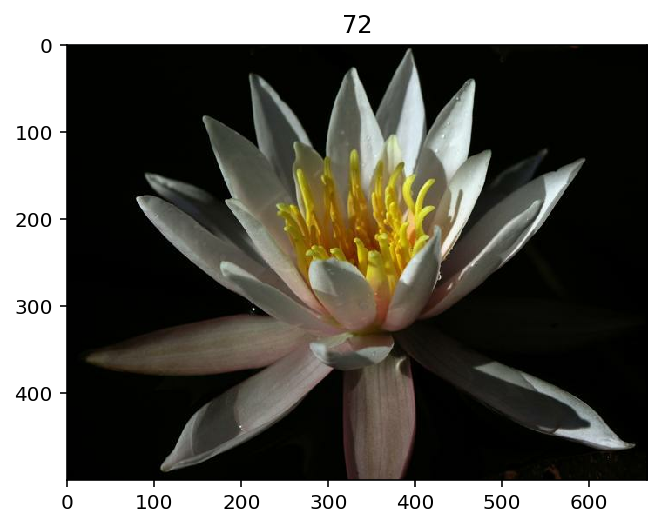

In [18]:
# TODO: Plot 1 image from the training set. 

# Set the title of the plot to the corresponding image label. 
for image, label in training_data.take(1):
    image = image.numpy()
    label = label.numpy()

plt.imshow(image)
plt.title(label)

### Label Mapping

You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [19]:
with open('label_map.json', 'r') as f:
    class_names = json.load(f)

In [20]:
type(list(class_names.keys())[0])

str

<class 'str'>


Text(0.5, 1.0, 'azalea')

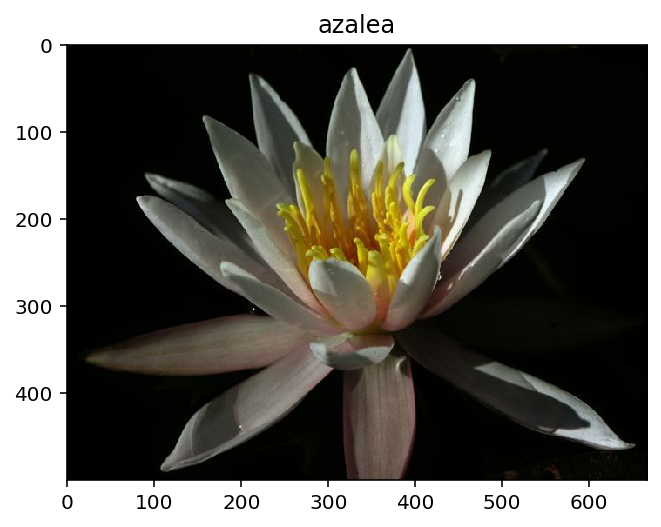

In [21]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding class name. 
for image, label in training_data.take(1):
    image = image.numpy()
    label = str(label.numpy())
    
print(type(label))

plt.imshow(image)
plt.title(class_names[label])

## Create Pipeline

Build a data pipeline for the MobileNet pretrained model which requires the input size (224,224,3) and normalize the image so that it is within range [0,1]. We need to shuffle the training data, separate them into batches and then apply mapping to resize and normalize it. For validation and testing data, we do the similar but do not need to shuffle.

In [22]:
# TODO: Create a pipeline for each set.
#define a function apply to the data tuple(image, label)
batch_size = 32
image_size = 224
def normalize_resize(image, label):
    image = tf.image.resize(image,(image_size, image_size))
    image = tf.cast(image, tf.float32)
    image /= 255
    return image, label

train_batch = training_data.shuffle(train_num//4).map(normalize_resize).batch(batch_size).prefetch(1)
vali_batch = validation_data.map(normalize_resize).batch(batch_size).prefetch(1)
test_batch = testing_data.map(normalize_resize).batch(batch_size).prefetch(1)       

# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. You should use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! 

Refer to the rubric for guidance on successfully completing this section. Things you'll need to do:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model. 

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right.

**Note for Workspace users:** One important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module. Also, If your model is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [23]:

#url for mobilenet
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
features_extractor = hub.KerasLayer(URL,
                                    input_shape = (image_size,image_size,3),
                                    trainable = False)
model = tf.keras.Sequential([features_extractor, 
                           tf.keras.layers.Dense(102, activation='softmax')
                            ])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 102)               130662    
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


In [24]:
#train the model
model.compile(optimizer = 'adam',
             loss='sparse_categorical_crossentropy',
             metrics = ['accuracy'])
EPOCHS = 20
history = model.fit(train_batch, 
                    epochs = EPOCHS, 
                    validation_data = vali_batch)

Epoch 1/20
32/32 [==============================] - 23s 713ms/step - loss: 4.2754 - accuracy: 0.0941 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 11s 352ms/step - loss: 2.0790 - accuracy: 0.7039 - val_loss: 1.9775 - val_accuracy: 0.6765
Epoch 3/20
32/32 [==============================] - 11s 354ms/step - loss: 1.1048 - accuracy: 0.8873 - val_loss: 1.5165 - val_accuracy: 0.7441
Epoch 4/20
32/32 [==============================] - 11s 346ms/step - loss: 0.6814 - accuracy: 0.9559 - val_loss: 1.2772 - val_accuracy: 0.7667
Epoch 5/20
32/32 [==============================] - 11s 347ms/step - loss: 0.4536 - accuracy: 0.9853 - val_loss: 1.1390 - val_accuracy: 0.7882
Epoch 6/20
32/32 [==============================] - 11s 344ms/step - loss: 0.3180 - accuracy: 0.9931 - val_loss: 1.0535 - val_accuracy: 0.8000
Epoch 7/20
32/32 [==============================] - 11s 350ms/step - loss: 0.2418 - accuracy: 0.9971 - val_loss: 0.9885 - val_accuracy

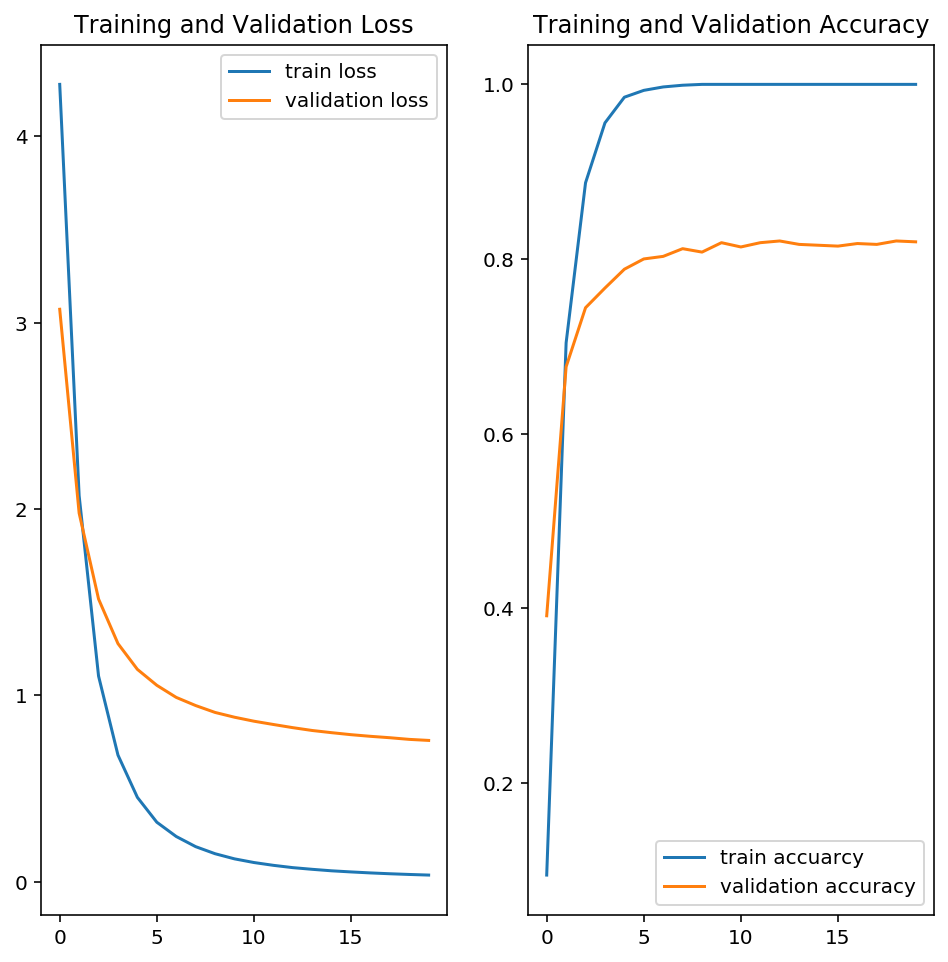

In [25]:
#Plot the loss and accuracy values achieved during training for the training and validation set.
#history.history is a dictionary with 4 keys: accuracy, loss, val_accuracy, val_loss
#EPOCHS=10
train_loss = history.history['loss']
train_accu = history.history['accuracy']
val_loss = history.history['val_loss']
val_accu = history.history['val_accuracy']
epochs_range = range(EPOCHS)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,train_loss, label = 'train loss')
plt.plot(epochs_range,val_loss, label = 'validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1,2,2)
plt.plot(epochs_range,train_accu, label = 'train accuarcy')
plt.plot(epochs_range,val_accu, label = 'validation accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()


In [26]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
features_extractor = hub.KerasLayer(URL,
                                    input_shape = (image_size,image_size,3),
                                    trainable = False)
model_with_stop = tf.keras.Sequential([features_extractor,tf.keras.layers.Dense(102, activation='softmax')])
model_with_stop.summary()

model_with_stop.compile(optimizer = 'adam',
                        loss='sparse_categorical_crossentropy',
                        metrics = ['accuracy'])
EPOCHS = 100
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)
history = model_with_stop.fit(train_batch,epochs = EPOCHS,validation_data = vali_batch,callbacks=[early_stopping])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 102)               130662    
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/100
32/32 [==============================] - 17s 526ms/step - loss: 4.2698 - accuracy: 0.1314 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
32/32 [==============================] - 11s 357ms/step - loss: 2.0853 - accuracy: 0.6902 - val_loss: 1.9956 - val_accuracy: 0.6471
Epoch 3/100
32/32 [==============================] - 11s 359ms/step - loss: 1.1129 - accuracy: 0.8882 - val_loss: 1.5250 - val_accuracy: 0.7255
Epoch 4/100
32/32 [==============================] - 11s 350

In [27]:
len(history.history['loss'])

100

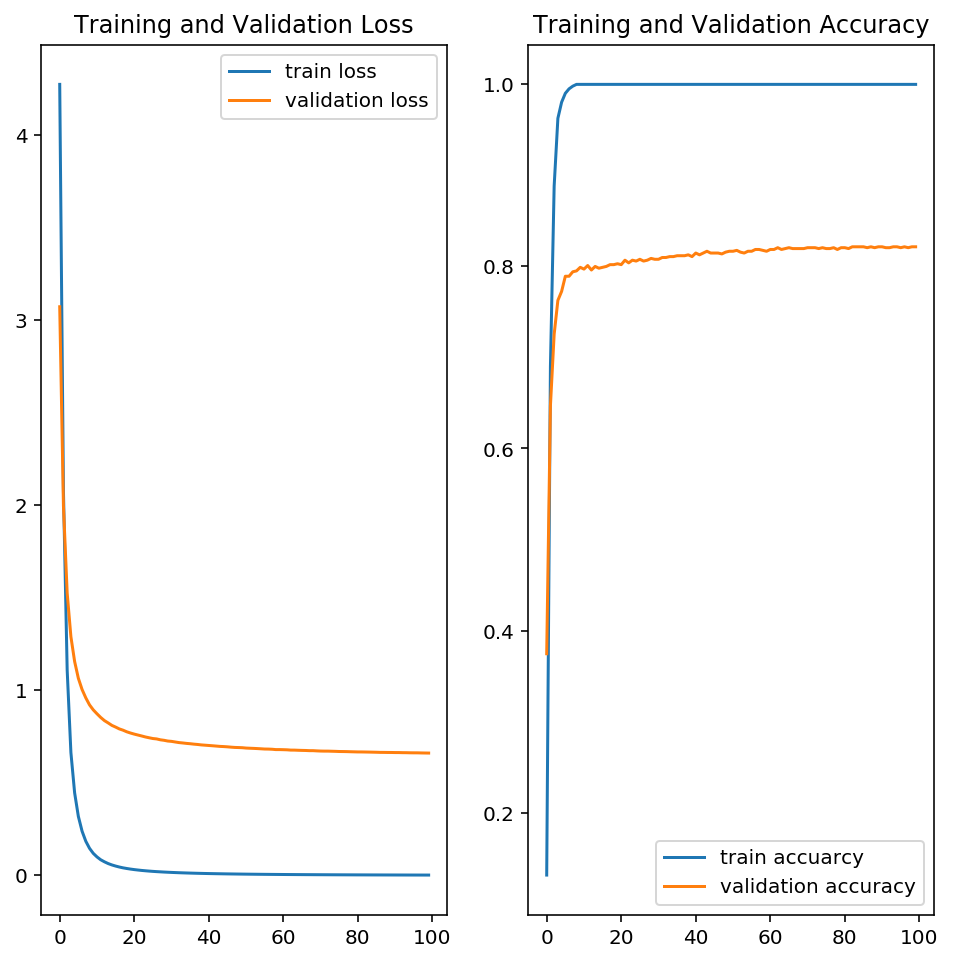

In [28]:
#Plot the loss and accuracy values achieved during training for the training and validation set.
#history.history is a dictionary with 4 keys: accuracy, loss, val_accuracy, val_loss

train_loss = history.history['loss']
train_accu = history.history['accuracy']
val_loss = history.history['val_loss']
val_accu = history.history['val_accuracy']
epochs_range = range(len(train_loss))

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,train_loss, label = 'train loss')
plt.plot(epochs_range,val_loss, label = 'validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1,2,2)
plt.plot(epochs_range,train_accu, label = 'train accuarcy')
plt.plot(epochs_range,val_accu, label = 'validation accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()

## Testing your Network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [29]:
# TODO: Print the loss and accuracy values achieved on the entire test set.
loss_sum, accuracy_sum = 0,0
count = 0
for image, label in test_batch:
    count += 1
    loss, accuracy = model_with_stop.evaluate(image, label)
    loss_sum += loss
    accuracy_sum += accuracy
    
loss_ave = loss_sum/count
accuracy_ave = accuracy_sum/count
print(f'the testing loss is {loss_ave:.3f},\nthe testing accuracy is {accuracy_ave:.3f}.')
    

5/1 [======================================================================================================================================================] - 1s 261ms/sample - loss: 0.0369 - accuracy: 1.0000
the testing loss is 0.806,
the testing accuracy is 0.792.


In [30]:
count

193

## Save the Model

Now that your network is trained, save the model so you can load it later for making inference. In the cell below save your model as a Keras model (*i.e.* save it as an HDF5 file).

In [31]:
# TODO: Save your trained model as a Keras model.
t = time.time()
keras_model_path  = f"./{int(t)}.h5"

model_with_stop.save(keras_model_path)


## Load the Keras Model

Load the Keras model you saved above.

In [32]:
# TODO: Load the Keras model

reload_model = tf.keras.models.load_model(keras_model_path,
                                          custom_objects={'KerasLayer':hub.KerasLayer})
reload_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 102)               130662    
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


# Inference for Classification

Now you'll write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. We recommend you write a separate function called `process_image` that performs the pre-processing. You can then call the `process_image` function from the `predict` function. 

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, you should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, you'll also need to normalize the pixel values. 

Finally, convert your image back to a NumPy array using the `.numpy()` method.

In [33]:
# TODO: Create the process_image function
def process_image(image):
    '''
    input an np.array image, convert it to a tensor, resize and normalize it, 
    output an np.array with shape (224,224,3)
    '''
    image = tf.convert_to_tensor(image)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image,(224,224))
    image /= 255
    return image.numpy()


To check your `process_image` function we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by your `process_image` function. If your `process_image` function works, the plotted image should be the correct size. 

In [34]:
image_path = './test_images/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)

In [35]:
type(im)

PIL.JpegImagePlugin.JpegImageFile

In [36]:
test_image = np.asarray(im)
test_image.shape

(591, 500, 3)

(224, 224, 3)


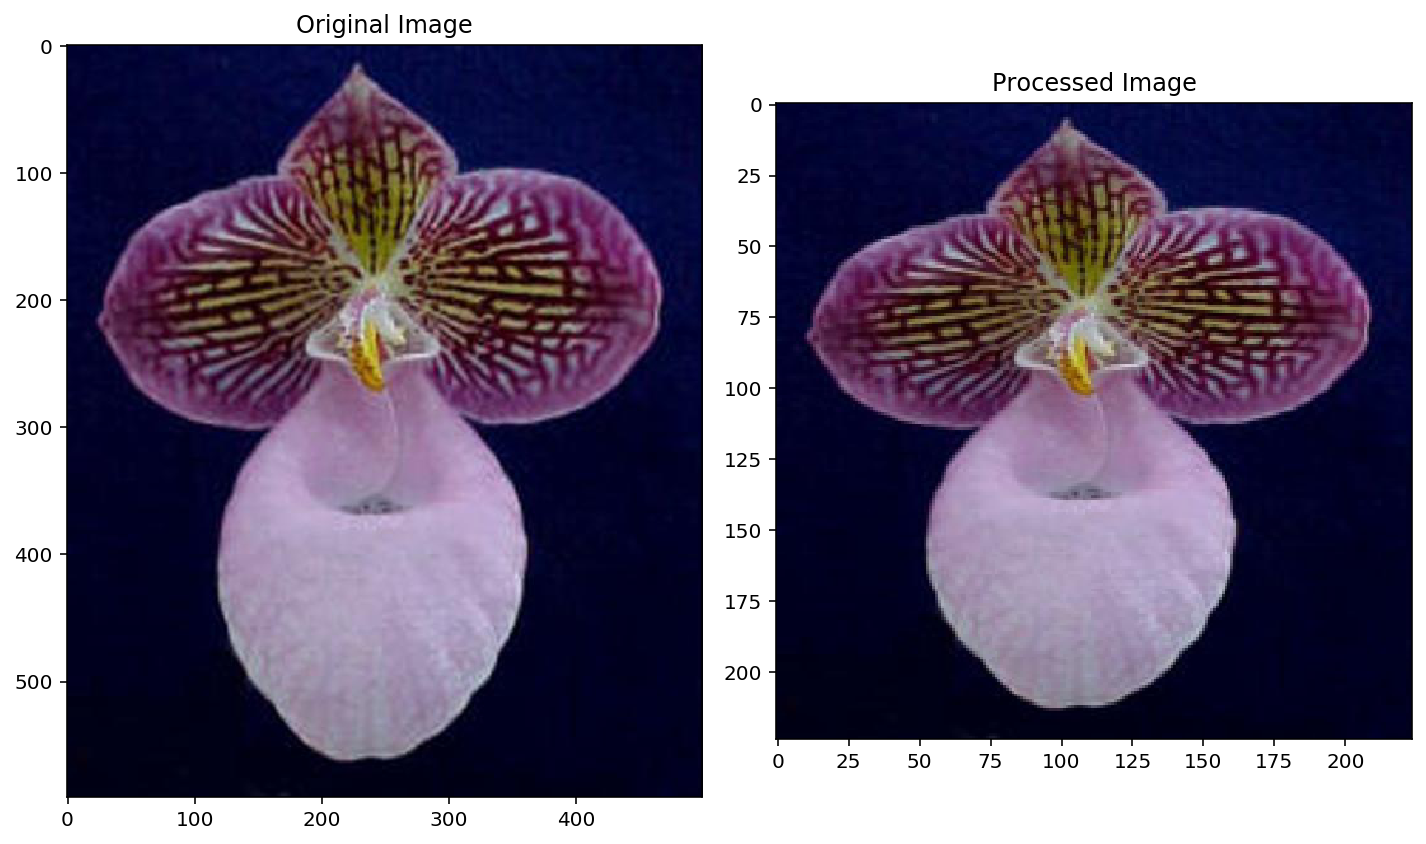

In [37]:
processed_test_image = process_image(test_image)
print(processed_test_image.shape)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

Once you can get images in the correct format, it's time to write the `predict` function for making inference with your model.

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We suggest you use the `np.expand_dims()` function to add the extra dimension. 

In [38]:

# TODO: Create the predict function
def predict(image_path, model, top_k):
    image = np.asarray(Image.open(image_path))
    image_processed = process_image(image)
    image_batch = np.expand_dims(image_processed, axis = 0)
    #the predicted probability has shape (1,102)
    pb = model.predict(image_batch)
    #take the biggest top_k indices
    arg_k = np.argsort(pb[0])[-top_k:][::-1]
    #take the biggest top_k probabilities
    pb_topk = pb[0][arg_k]
    return pb_topk, arg_k

In [39]:
# use the reload_model for prediction
# get the top 5 probabilties and its indices
top_k = 5
probs, indices = predict(image_path, reload_model, top_k)

In [41]:
probs

array([9.9978346e-01, 4.6299818e-05, 3.2723645e-05, 2.6532734e-05,
       2.5649953e-05], dtype=float32)

In [42]:
indices

array([ 1, 67, 79,  6, 76])

# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:

<img src='assets/inference_example.png' width=600px>

You can convert from the class integer labels to actual flower names using `class_names`. 

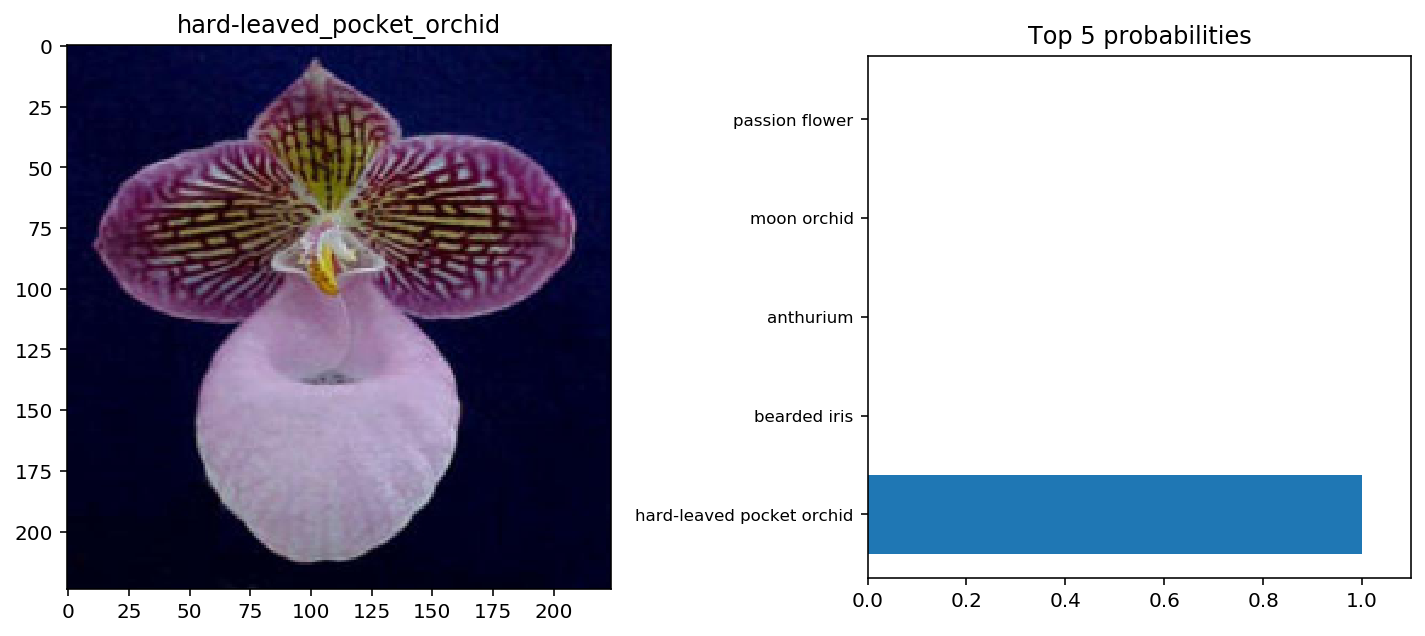

In [56]:
# another image
image_path = './test_images/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)
processed_test_image = process_image(test_image)
# use the reload_model for prediction
# get the top 5 probabilties and its indices
top_k = 5
probs, indices = predict(image_path, reload_model, top_k)



fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(processed_test_image)
ax1.set_title('hard-leaved_pocket_orchid')
ax2.barh(y=np.arange(top_k), width = probs)
names = [class_names[str(i+1)] for i in indices]
ax2.set_aspect(0.2)
ax2.set_yticks(np.arange(top_k))
ax2.set_yticklabels(names, size ='small')
ax2.set_title('Top 5 probabilities')
ax2.set_xlim(0,1.1)
plt.tight_layout()
plt.show()

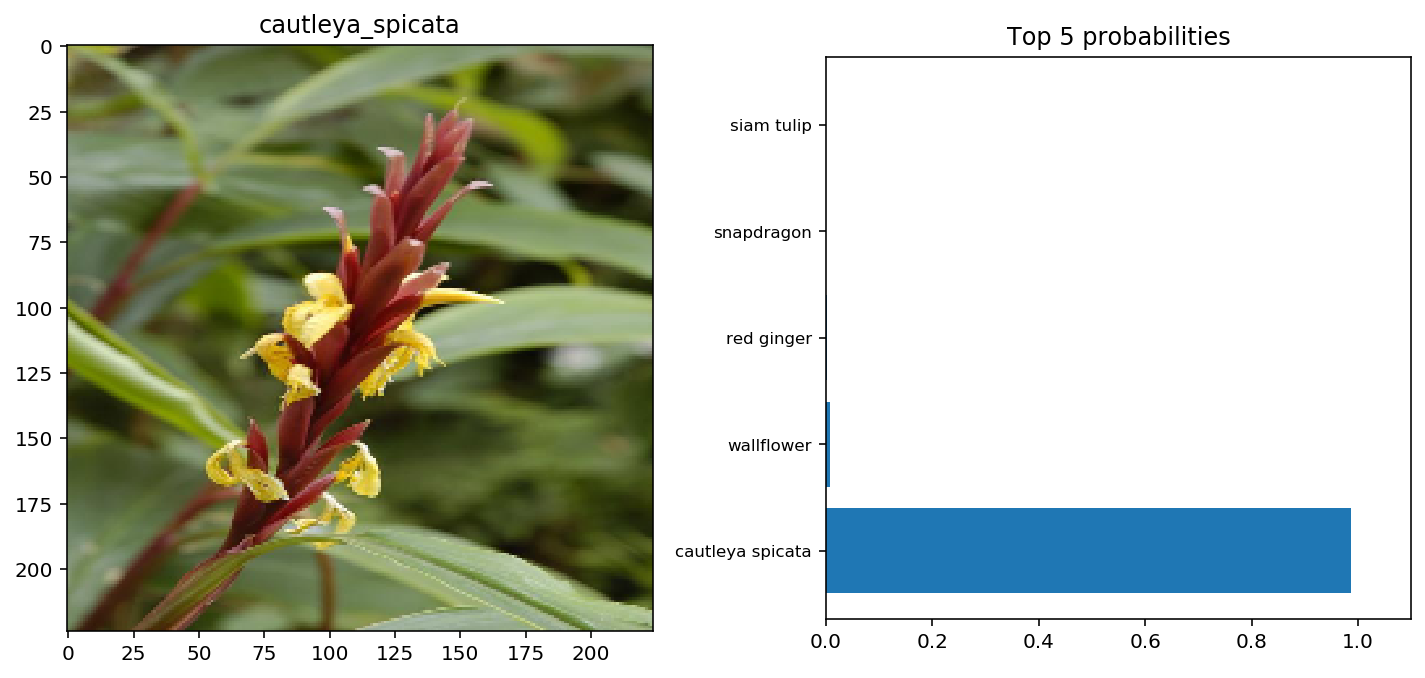

In [57]:
# another image
image_path = './test_images/cautleya_spicata.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)
processed_test_image = process_image(test_image)
# use the reload_model for prediction
# get the top 5 probabilties and its indices
top_k = 5
probs, indices = predict(image_path, reload_model, top_k)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(processed_test_image)
ax1.set_title('cautleya_spicata')
ax2.barh(y=np.arange(top_k), width = probs)
names = [class_names[str(i+1)] for i in indices]
ax2.set_aspect(0.2)
ax2.set_yticks(np.arange(top_k))
ax2.set_yticklabels(names, size ='small')
ax2.set_title('Top 5 probabilities')
ax2.set_xlim(0,1.1)
plt.tight_layout()
plt.show()

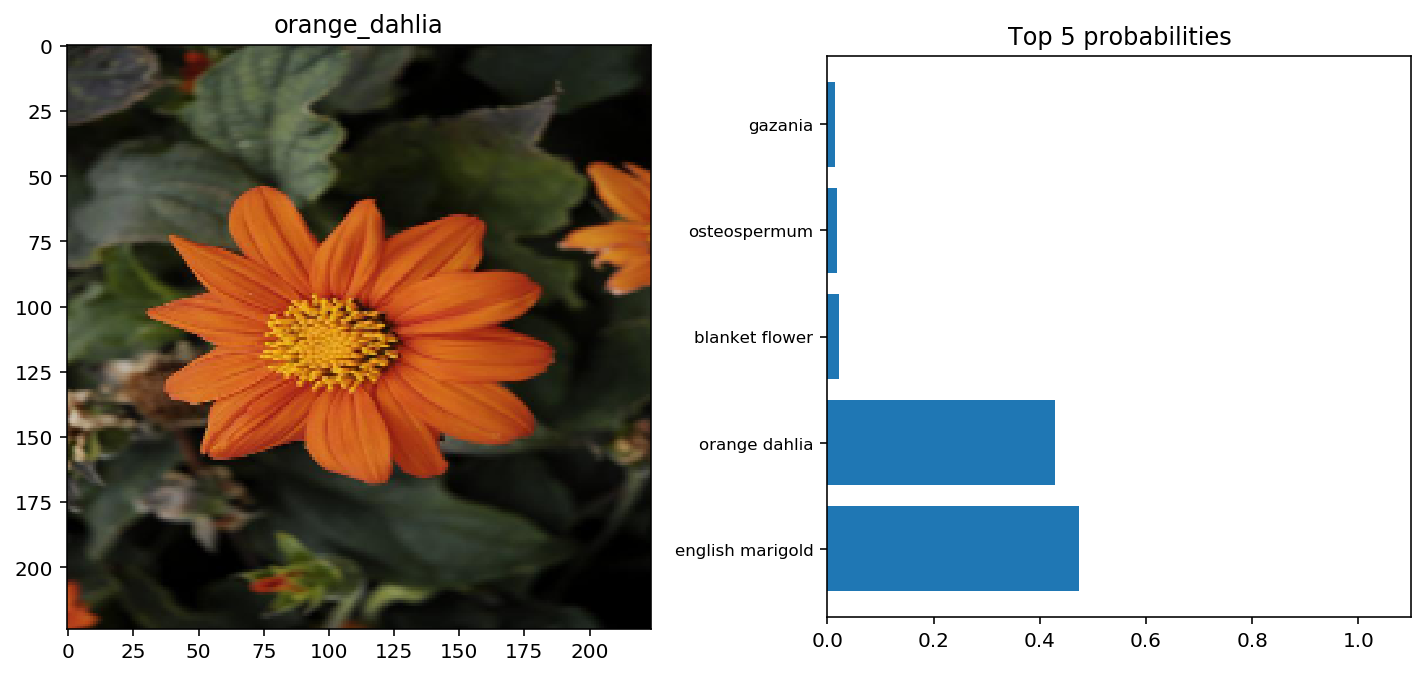

In [58]:
# another image
image_path = './test_images/orange_dahlia.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)
processed_test_image = process_image(test_image)
# use the reload_model for prediction
# get the top 5 probabilties and its indices
top_k = 5
probs, indices = predict(image_path, reload_model, top_k)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(processed_test_image)
ax1.set_title('orange_dahlia')
ax2.barh(y=np.arange(top_k), width = probs)
names = [class_names[str(i+1)] for i in indices]
ax2.set_aspect(0.2)
ax2.set_yticks(np.arange(top_k))
ax2.set_yticklabels(names, size ='small')
ax2.set_title('Top 5 probabilities')
ax2.set_xlim(0,1.1)
plt.tight_layout()
plt.show()

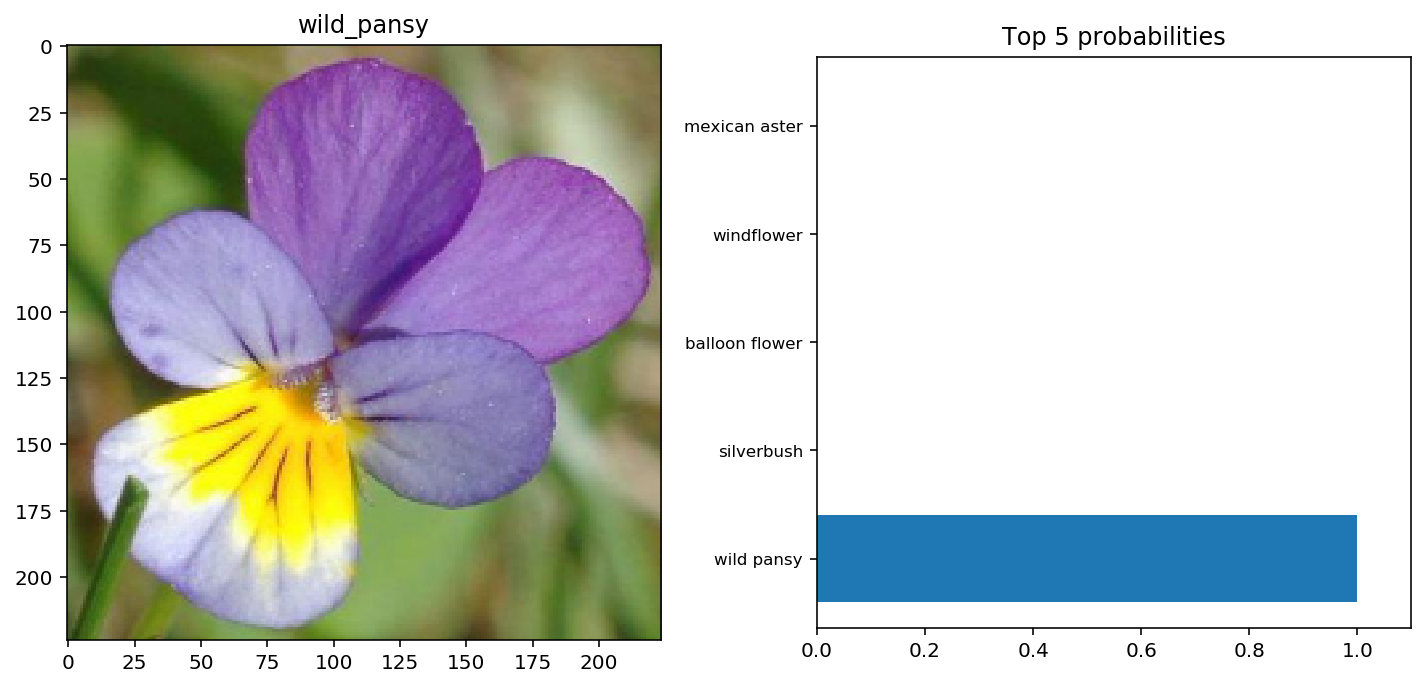

In [59]:
# another image
image_path = './test_images/wild_pansy.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)
processed_test_image = process_image(test_image)
# use the reload_model for prediction
# get the top 5 probabilties and its indices
top_k = 5
probs, indices = predict(image_path, reload_model, top_k)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(processed_test_image)
ax1.set_title('wild_pansy')
ax2.barh(y=np.arange(top_k), width = probs)
names = [class_names[str(i+1)] for i in indices]
ax2.set_aspect(0.2)
ax2.set_yticks(np.arange(top_k))
ax2.set_yticklabels(names, size ='small')
ax2.set_title('Top 5 probabilities')
ax2.set_xlim(0,1.1)
plt.tight_layout()
plt.show()